In [1]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from model_settings import ms
from plotters import PlotCols
import matplotlib.pyplot as plt

ms.find_root(Path())

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

# loading model

In [3]:
root = os.path.join(ms.root)
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if not f.startswith('.') and f.find('Legacy')])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 112825652640 cboe spx relative asian
1     2024-11-09 124653897492 cboe spx relative barrier


In [4]:
selected_model = models.iloc[1]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'seed': 1312,
 'raw_data':          spot_price  strike_price  barrier  days_to_maturity updown outin  \
 0            1274.0        1146.6    637.0                60   Down   Out   
 1            1274.0        1146.6    637.0                60   Down   Out   
 2            1274.0        1146.6    637.0                60   Down    In   
 3            1274.0        1146.6    637.0                60   Down    In   
 4            1274.0        1146.6    637.0                90   Down   Out   
 ...             ...           ...      ...               ...    ...   ...   
 4067275      5857.0        6442.7   8785.5               540     Up    In   
 4067276      5857.0        6442.7   8785.5               720     Up   Out   
 4067277      5857.0        6442.7   8785.5               720     Up   Out   
 4067278      5857.0        6442.7   8785.5               720     Up    In   
 4067279      5857.0        6442.7   8785.5               720     Up    In   
 
             w barrier_type_name  r

In [5]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [6]:
unretrained = model['model']

In [44]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

theta: 
0       8.181674e-11
1       4.564269e-10
2       4.968155e-10
3       6.916618e-10
4       1.119760e-09
            ...     
1747    1.700398e+00
1748    1.732709e+00
1749    1.811241e+00
1750    1.836051e+00
1751    1.869788e+00
Name: theta, Length: 1752, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e

In [45]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])

['days_to_maturity', 'dividend_rate', 'risk_free_rate', 'theta', 'kappa', 'rho', 'eta', 'v0', 'relative_spot', 'relative_barrier', 'relative_rebate', 'w', 'barrier_type_name']


# retraining

In [46]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [47]:
train_data = model['train_data']
insample_error = train_data['insample_error']
insample_RMSE = np.sqrt(np.mean(insample_error))
insample_MAE = np.mean(np.abs(insample_error))
train_desc = train_data[['spot_price','v0','insample_error']].copy()
train_desc['sqrtv0'] = np.sqrt(train_desc['v0'])
train_desc = train_desc[['spot_price','sqrtv0']].drop_duplicates().reset_index(drop=True)

In [48]:
test_dates = model['test_dates']
full_dataset = model['dataset']
pricename = [f[:f.find('_',0)] for f in full_dataset.columns if f.find('asian_price')!=-1 or f.find('barrier_price')!=-1][0]
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates = pd.to_datetime(all_dates,format='mixed')
# i = 0
# for date in all_dates:
#     i += 1
#     plt.scatter(date,i)

retraining_frequency = 20

n = model['test_dates'].shape[0]//retraining_frequency

In [55]:
cols = ['outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame()

models = {}


for i in range(0,n):
    development_dates = pd.to_datetime(model['development_dates'],format='mixed')
    subset_test_dates = pd.to_datetime(model['test_dates'][(i*retraining_frequency):(i+1)*retraining_frequency],format='fixed')
    # print(f"training:  {min(development_dates).strftime('%A, %d %B, %Y')}  -  {max(development_dates).strftime('%A, %d %B, %Y')} ({len(development_dates)} trading days)")
    # print(f"testing:   {min(subset_test_dates).strftime('%A, %d %B, %Y')}  -  {max(subset_test_dates).strftime('%A, %d %B, %Y')} ({len(subset_test_dates)} trading days)")
    test_data = full_dataset[full_dataset['date'].isin(subset_test_dates)]

    target = test_data['relative_observed']
    prediction = unretrained.predict(test_data[model['feature_set']])
    error = prediction-target
    date = subset_test_dates.iloc[0]
    df.at[date,'outofsample_MAE'] = compute_MAE(error)
    df.at[date,'outofsample_RMSE'] = compute_RMSE(error)
    df.at[date,'avgsqrtv0'] = np.mean(np.sqrt(test_data['v0']))
    df.at[date,'avgeta'] = np.mean(np.sqrt(test_data['eta']))
    # print(df.dropna())
    # print('\n','%'*10,'\n')

df.index = pd.to_datetime(df.index)
df

,outofsample_MAE,outofsample_RMSE,avgsqrtv0,avgeta
2012-11-06,0.029246,0.082990,0.252766,1.179574
2013-02-04,0.048972,0.120293,0.188218,1.115109
2013-04-25,0.019523,0.064073,0.198415,1.257831
2013-06-10,0.026416,0.074017,0.251893,1.151280
2013-08-09,0.022915,0.066865,0.166285,1.126695
...,...,...,...,...
2023-08-31,0.648231,0.661945,0.222199,1.313550
2023-11-08,0.640448,0.649659,0.217756,1.506227
2024-01-25,0.626490,0.634265,0.280416,1.485188
2024-03-26,0.640570,0.652625,0.229020,1.456290


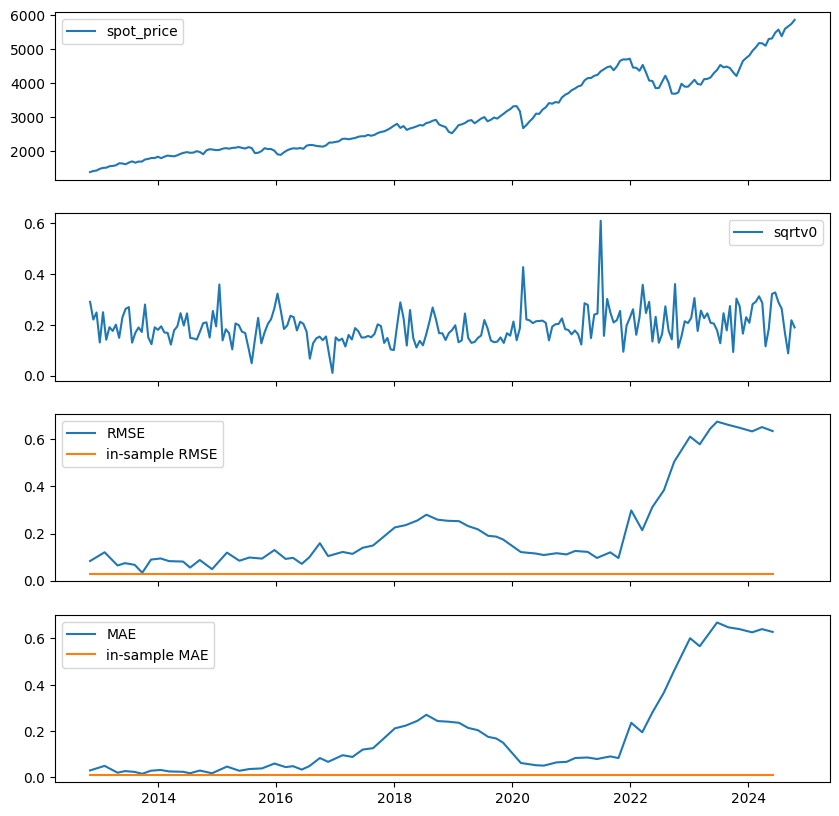

In [56]:
fig,axs = plt.subplots(len(plotdf.columns)+2,figsize=(10,10),sharex=True)
for i,col in enumerate(plotdf.columns):
    axs[i].plot(plotdf[col],label=col)
    axs[i].legend()

axs[i+1].plot(df['outofsample_RMSE'],label='RMSE')
axs[i+1].plot(df['outofsample_RMSE'].index,np.tile(insample_RMSE,df.shape[0]),label='in-sample RMSE')
axs[i+1].legend()
axs[i+2].plot(df['outofsample_MAE'],label='MAE')
axs[i+2].plot(df['outofsample_MAE'].index,np.tile(insample_MAE,df.shape[0]),label='in-sample MAE')
axs[i+2].legend()
plt.show()

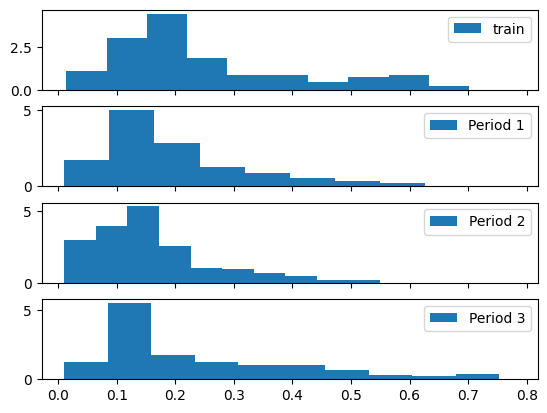

In [57]:
"""
"""
test_data = model['test_data'].copy()
P1a = test_data[test_data['date']<=pd.Timestamp(2017,1,1)].copy()
P1b = test_data[(test_data['date']>=pd.Timestamp(2020,1,1))&(test_data['date']<=pd.Timestamp(2022,1,1))]
P1 = pd.concat([P1a,P1b],ignore_index=True)
P2 = test_data[(test_data['date']>pd.Timestamp(2017,1,1))&(test_data['date']<pd.Timestamp(2020,1,1))]
P3 = test_data[test_data['date']>=pd.Timestamp(2022,1,1)]

P1 = P1[['spot_price','v0']].drop_duplicates()
P1['sqrtv0'] = np.sqrt(P1['v0'])
P1 = P1.drop(columns='v0')

P2 = P2[['spot_price','v0']].drop_duplicates()
P2['sqrtv0'] = np.sqrt(P2['v0'])
P2 = P2.drop(columns='v0')

P3 = P3[['spot_price','v0']].drop_duplicates()
P3['sqrtv0'] = np.sqrt(P3['v0'])
P3 = P3.drop(columns='v0')

fig,axs = plt.subplots(4,sharex=True)
axs[0].hist(train_desc['sqrtv0'],density=True,bins=10,label='train')
axs[0].legend()
axs[1].hist(P1['sqrtv0'],density=True,bins=10,label='Period 1')
axs[1].legend()
axs[2].hist(P2['sqrtv0'],density=True,bins=10,label='Period 2')
axs[2].legend()
axs[3].hist(P3['sqrtv0'],density=True,bins=10,label='Period 3')
axs[3].legend()
plt.show()

In [58]:
test_data['sqrtv0'] = np.sqrt(test_data['v0'])
p0 = test_data['sqrtv0'].describe()['min']
p25 = test_data['sqrtv0'].describe()['25%']
p50 = test_data['sqrtv0'].describe()['50%']
p75 = test_data['sqrtv0'].describe()['75%']
p100 = test_data['sqrtv0'].describe()['max']

In [16]:
test_data['date'].describe()

count                            55371
mean     2024-07-07 07:35:09.833667328
min                2024-05-31 00:00:00
25%                2024-06-24 00:00:00
50%                2024-07-10 00:00:00
75%                2024-07-18 00:00:00
max                2024-08-02 00:00:00
Name: date, dtype: object

In [20]:
train_desc['sqrtv0']

0      0.111489
1      0.530941
2      0.198276
3      0.132810
4      0.013718
         ...   
126    0.436790
127    0.178747
128    0.194792
129    0.183097
130    0.237960
Name: sqrtv0, Length: 131, dtype: float64

train:
        spot_price      sqrtv0
count   131.000000  131.000000
mean   1367.137405    0.250794
std      46.750527    0.160850
min    1274.000000    0.013718
25%    1328.500000    0.135214
50%    1366.000000    0.198276
75%    1404.500000    0.327081
max    1463.000000    0.702182

test:
        spot_price       sqrtv0
count  1752.000000  1752.000000
mean   2992.363584     0.194906
std    1095.787782     0.135324
min    1356.000000     0.010116
25%    2063.000000     0.111623
50%    2759.000000     0.153286
75%    3998.750000     0.244846
max    5863.000000     0.780206


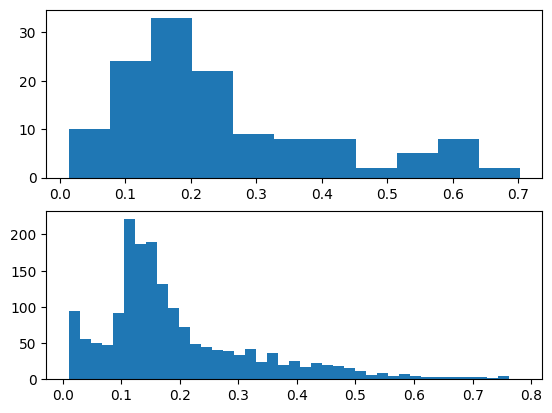

In [51]:
print('train:')
print(test_desc.describe())
print('\ntest:')
print(plotdf[['spot_price','sqrtv0']].describe())
fig,axs = plt.subplots(2)
test_sqrtv0 = test_desc['sqrtv0']
train_sqrtv0 = plotdf['sqrtv0']
axs[0].hist(test_sqrtv0,bins=int(np.sqrt(len(test_sqrtv0))))
axs[1].hist(plotdf['sqrtv0'],bins=int(np.sqrt(len(train_sqrtv0))))
plt.show()